In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import Libraries

In [5]:
import os
import h5py
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import h5py

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

# Preprocessing

In [2]:
def preprocess_combined_features_ml(hdf5_path):
    # Load data
    with h5py.File(hdf5_path, 'r') as file:
        images = np.array(file['images'])
        labels = np.array(file['labels'])

    # Process each image
    processed_images = []
    for image in images:
        # Resize to standard size
        image = cv2.resize(image, (512, 512))

        # Apply median blur to reduce noise while preserving edges
        denoised = cv2.medianBlur(image, 3)

        # Convert to HSV for better color representation
        hsv = cv2.cvtColor(denoised, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)

        # Enhance saturation and value channels
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_s = clahe.apply(s)
        enhanced_v = clahe.apply(v)

        # Merge channels
        enhanced_hsv = cv2.merge([h, enhanced_s, enhanced_v])
        enhanced_color = cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2BGR)

        # Apply edge-preserving filter
        edge_preserved = cv2.edgePreservingFilter(enhanced_color,
                                                flags=cv2.RECURS_FILTER,
                                                sigma_s=60,
                                                sigma_r=0.4)

        # Enhance local contrast
        lab = cv2.cvtColor(edge_preserved, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        enhanced_l = clahe.apply(l)
        enhanced_lab = cv2.merge([enhanced_l, a, b])
        result = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

        # Convert to grayscale and flatten
        gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
        flattened = gray.flatten()

        processed_images.append(flattened)

    # Convert to numpy array
    processed_images = np.array(processed_images)

    # Apply MinMax scaling
    minmax_scaler = MinMaxScaler()
    images_standardized = minmax_scaler.fit_transform(processed_images)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(
        images_standardized,
        labels,
        test_size=0.25,
        shuffle=True,
        stratify=labels,
        random_state=42
    )

    return X_train, X_test, y_train, y_test

In [3]:
path = '/content/drive/MyDrive/TCV_Project/dataset.hdf5'

In [6]:
# Load and preprocess data
X_train, X_test, y_train, y_test = preprocess_combined_features_ml(path)

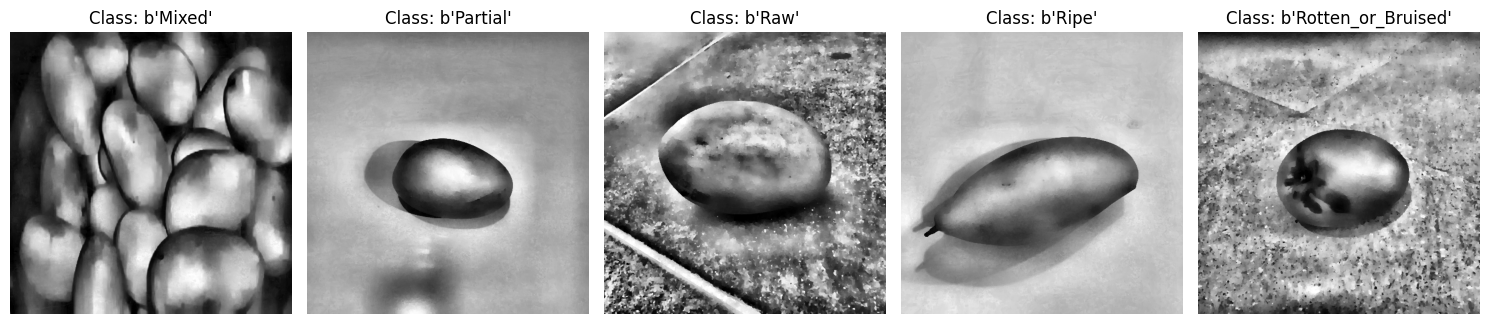

In [7]:
image_size = 512
X_train_reshaped = X_train.reshape(-1, image_size, image_size)


# Get unique classes
unique_classes = np.unique(y_train)

# Plot an example image from each class
plt.figure(figsize=(15, 5))
for i, class_label in enumerate(unique_classes):
    # Find the index of the first image belonging to the current class
    class_indices = np.where(y_train == class_label)[0]
    if len(class_indices)>0:
      image_index = class_indices[0]

      plt.subplot(1, len(unique_classes), i + 1)
      plt.imshow(X_train_reshaped[image_index], cmap='gray')
      plt.title(f'Class: {class_label}')
      plt.axis('off')

plt.tight_layout()
plt.show()


In [8]:
# Apply PCA
n_components = 50
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)


pca.fit(X_train, y_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

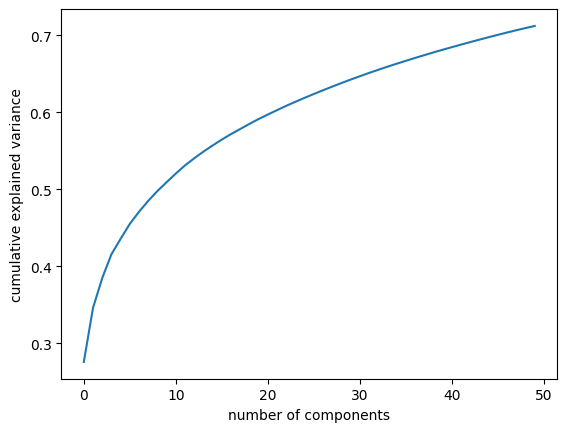

In [9]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

# SVM

In [10]:
# With Standard Function PCA
svc_classifier_pca = SVC()
svc_classifier_pca.fit(X_train_pca, y_train)
y_pred_pca_svc = svc_classifier_pca.predict(X_test_pca)

print("With Standard Function PCA(SVC)")
print(classification_report(y_test, y_pred_pca_svc, zero_division=1))

With Standard Function PCA(SVC)
                      precision    recall  f1-score   support

            b'Mixed'       1.00      0.00      0.00         4
          b'Partial'       0.86      0.53      0.65        34
              b'Raw'       0.81      0.91      0.86       188
             b'Ripe'       0.79      0.84      0.81       127
b'Rotten_or_Bruised'       0.74      0.45      0.56        38

            accuracy                           0.80       391
           macro avg       0.84      0.55      0.58       391
        weighted avg       0.80      0.80      0.79       391



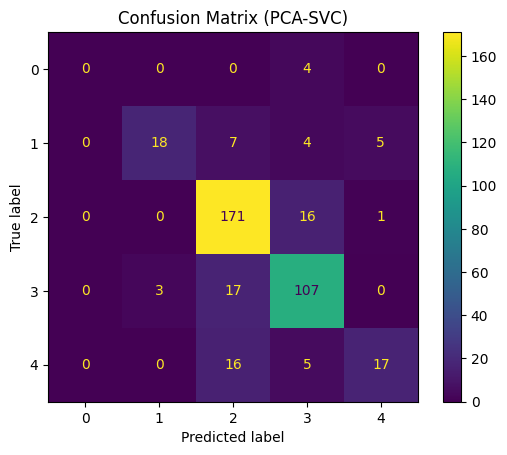

In [11]:
cm = confusion_matrix(y_test, y_pred_pca_svc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (PCA-SVC)")
plt.savefig("Confusion Matrix(PCA-SVC).jpg") # Save the plot
plt.show()

# KNN

In [12]:
# With Standard Function PCA
knn_classifier_pca = KNeighborsClassifier(n_neighbors=5)
knn_classifier_pca.fit(X_train_pca, y_train)
y_pred_knn_pca = knn_classifier_pca.predict(X_test_pca)

print("KNN Classification Report: pca_std")
print(classification_report(y_test, y_pred_knn_pca, zero_division=1))

KNN Classification Report: pca_std
                      precision    recall  f1-score   support

            b'Mixed'       1.00      0.00      0.00         4
          b'Partial'       0.36      0.59      0.44        34
              b'Raw'       0.69      0.87      0.77       188
             b'Ripe'       0.86      0.52      0.65       127
b'Rotten_or_Bruised'       0.58      0.29      0.39        38

            accuracy                           0.67       391
           macro avg       0.70      0.45      0.45       391
        weighted avg       0.71      0.67      0.66       391



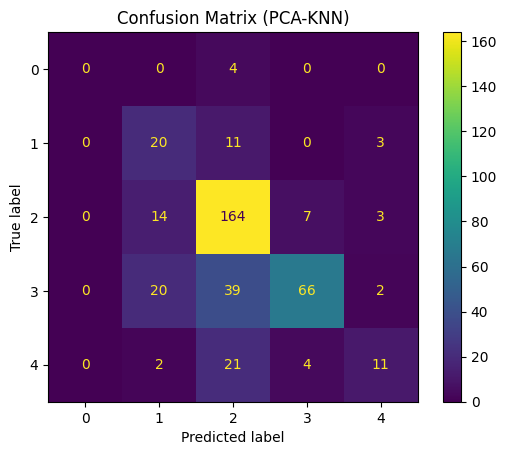

In [13]:
cm = confusion_matrix(y_test, y_pred_knn_pca)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (PCA-KNN)")
plt.savefig("Confusion Matrix(PCA-KNN).jpg") # Save the plot
plt.show()

# XGBoost

In [14]:
# With Standard Function PCA
xgboost_classifier_pca = GradientBoostingClassifier()
xgboost_classifier_pca.fit(X_train_pca, y_train)
y_pred_xgboost_pca = xgboost_classifier_pca.predict(X_test_pca)

print("XGBoost Classification Report: pca_std")
print(classification_report(y_test, y_pred_xgboost_pca, zero_division=1))

XGBoost Classification Report: pca_std
                      precision    recall  f1-score   support

            b'Mixed'       1.00      0.00      0.00         4
          b'Partial'       0.83      0.56      0.67        34
              b'Raw'       0.80      0.85      0.82       188
             b'Ripe'       0.73      0.83      0.78       127
b'Rotten_or_Bruised'       0.74      0.45      0.56        38

            accuracy                           0.77       391
           macro avg       0.82      0.54      0.56       391
        weighted avg       0.77      0.77      0.76       391



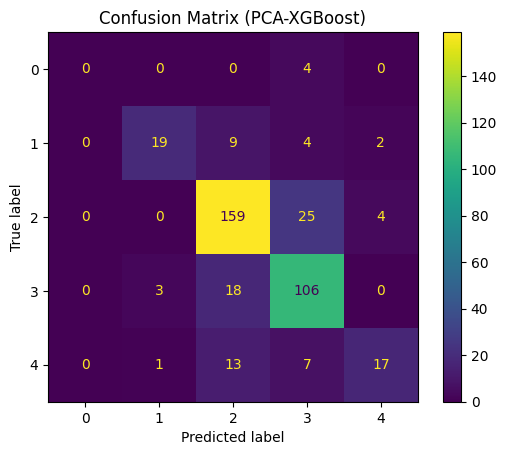

In [15]:
cm = confusion_matrix(y_test, y_pred_xgboost_pca)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (PCA-XGBoost)")
plt.savefig("Confusion Matrix(PCA-XGBoost).jpg") # Save the plot
plt.show()